# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/bias1/"

Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.056300*(x0-0.151315)-0.056060*(x1-0.237481)-0.040333*(x2-0.242262)-0.039417*(x3-0.381738)-0.006150*(x4-0.469353)+0.193708*(x5-0.466445)-0.096653*(x6-0.520943)+0.040886*(x7-0.516086)-0.077842*(x8-0.630814)+0.096172*(x9-0.122449)+0.008611*(x10-0.133310)+0.156356*(x11-0.247880)+0.021073*(x12-0.353029)-0.691887*(x13-0.342136)+0.380808*(x14-0.416406)+0.160515*(x15-0.389337)+0.055614*(x16-0.517110)-0.018962*(x17-0.224847)-0.046943*(x18-0.284511)-0.009359*(x19-0.397087)+0.162445*(x20-0.369126)-0.105685*(x21-0.460116)-0.030948*(x22-0.386087)-0.005032*(x23-0.510878)-0.057829*(x24-0.146756)-0.007170*(x25-0.243785)+0.284501*(x26-0.250046)-0.163119*(x27-0.313928)-0.193802*(x28-0.330685)+0.072464*(x29-0.462732)+0.033672*(x30-0.153860)+0.119815*(x31-0.154688)-0.052352*(x32-0.241706)-0.007349*(x33-0.246343)-0.044449*(x34-0.385587)-0.137937*(x35-0.256990)+0.065022*(x36-0.306152)+0.051915*(x37-0.352969)-0.004309*(x38-0.481968)-0.044664*(x39-0.123106)-0.039540*(x40-0.134070)+0.020214*(x41-0.248322)+0.060642*(x42-0.225088)-0.013393*(x43-0.283744)-0.009009*(x44-0.146389) PERIODIC=NO
tica_cv2: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.003183*(x0-0.151315)-0.006897*(x1-0.237481)-0.012530*(x2-0.242262)+0.107473*(x3-0.381738)-0.009760*(x4-0.469353)-0.376792*(x5-0.466445)+0.154544*(x6-0.520943)+0.187892*(x7-0.516086)-0.039757*(x8-0.630814)+0.004213*(x9-0.122449)+0.039232*(x10-0.133310)-0.179992*(x11-0.247880)+0.020357*(x12-0.353029)+0.666440*(x13-0.342136)-0.293921*(x14-0.416406)-0.350661*(x15-0.389337)+0.083674*(x16-0.517110)-0.018248*(x17-0.224847)+0.068983*(x18-0.284511)-0.009278*(x19-0.397087)-0.226836*(x20-0.369126)+0.100713*(x21-0.460116)+0.105074*(x22-0.386087)-0.022229*(x23-0.510878)+0.015934*(x24-0.146756)-0.002318*(x25-0.243785)-0.071674*(x26-0.250046)+0.028551*(x27-0.313928)+0.043965*(x28-0.330685)-0.008747*(x29-0.462732)+0.007341*(x30-0.153860)+0.009912*(x31-0.154688)+0.001311*(x32-0.241706)+0.003437*(x33-0.246343)-0.001854*(x34-0.385587)-0.021675*(x35-0.256990)+0.006868*(x36-0.306152)+0.002693*(x37-0.352969)+0.006042*(x38-0.481968)+0.031041*(x39-0.123106)+0.037449*(x40-0.134070)-0.019277*(x41-0.248322)-0.022528*(x42-0.225088)+0.004927*(x43-0.283744)-0.002141*(x44-0.146389) PERIODIC=NO
# bias 
opes: OPES_METAD ARG=tica_cv1,tica_cv2 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

In [4]:
data = load_dataframe(folder+"COLVAR")
olddata = load_dataframe("unbias_A/COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

## Adding the unbias data to the bias one
In order to use also the old data to obtain an estime on the fly of TICA cv we need to concat both data together  
The time of the bias data must be increase by the last valued of the old_data last time

In [5]:
data["time"] = data["time"] + olddata["time"].tail(1).values
data["opes.bias"] = data["opes.bias"]-min(data["opes.bias"])
newdata = pd.concat([ olddata,data],ignore_index=True).replace(np.nan, 0)

In [83]:
newdata = load_dataframe(folder+"COLVAR")

Text(0, 0.5, '$\\psi$')

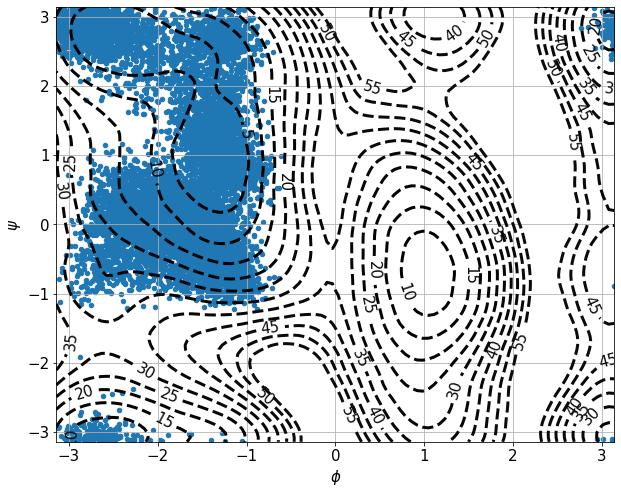

In [84]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
#load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)
newdata.plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

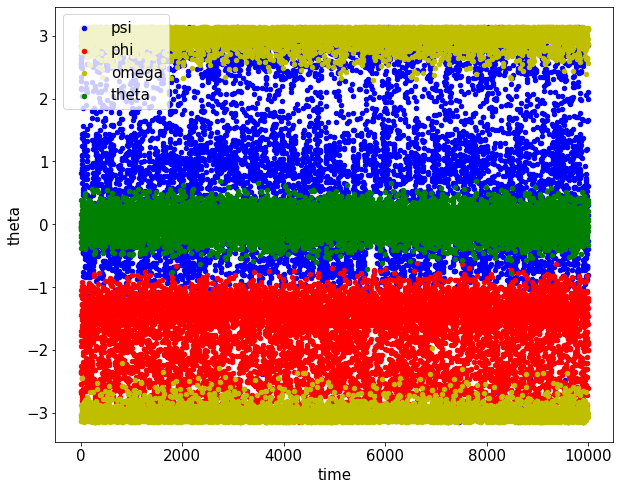

In [85]:
#data = load_dataframe(folder+"COLVAR")
fig,ax = plt.subplots(1,1,figsize=(10,8))
newdata.plot.scatter(x="time",y="psi",ax=ax, color="b", label="psi")
newdata.plot.scatter(x="time",y="phi",ax=ax, color="r", label="phi")
newdata.plot.scatter(x="time",y="omega",ax=ax, color="y", label="omega")
newdata.plot.scatter(x="time",y="theta",ax=ax, color="g", label="theta")
ax.legend()

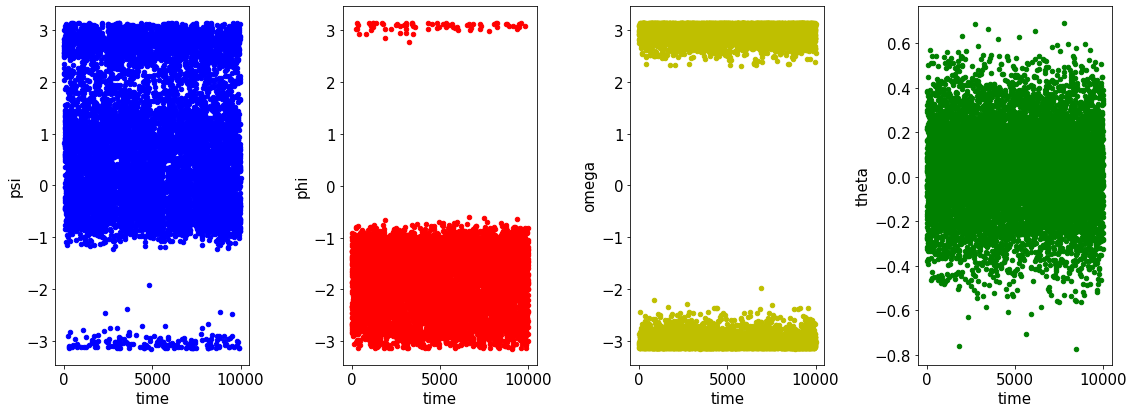

In [86]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
newdata.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
newdata.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
newdata.plot.scatter(x="time",y="omega",ax=axs[2], color="y")
newdata.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

<AxesSubplot:xlabel='psi', ylabel='omega'>

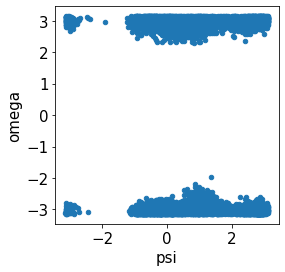

In [87]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
#load_dataframe(folder+"COLVAR").plot.scatter(y="omega",x="psi",ax=ax)
newdata.plot.scatter(y="omega",x="psi",ax=ax)

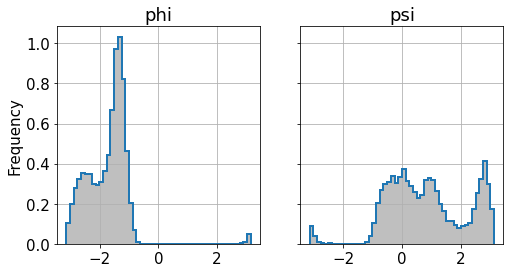

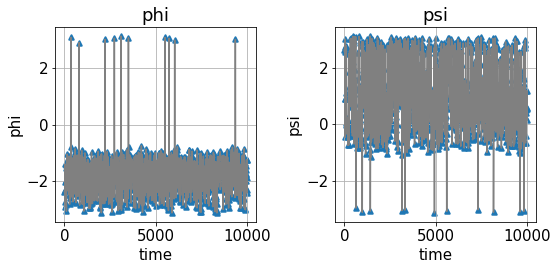

In [88]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    newdata[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    newdata[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(8,4))

for ax,desc in zip(axs.flatten(),descriptors_names):
    newdata[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    newdata[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [89]:
#gridspec_fes(s,logweight,sim_parameters)

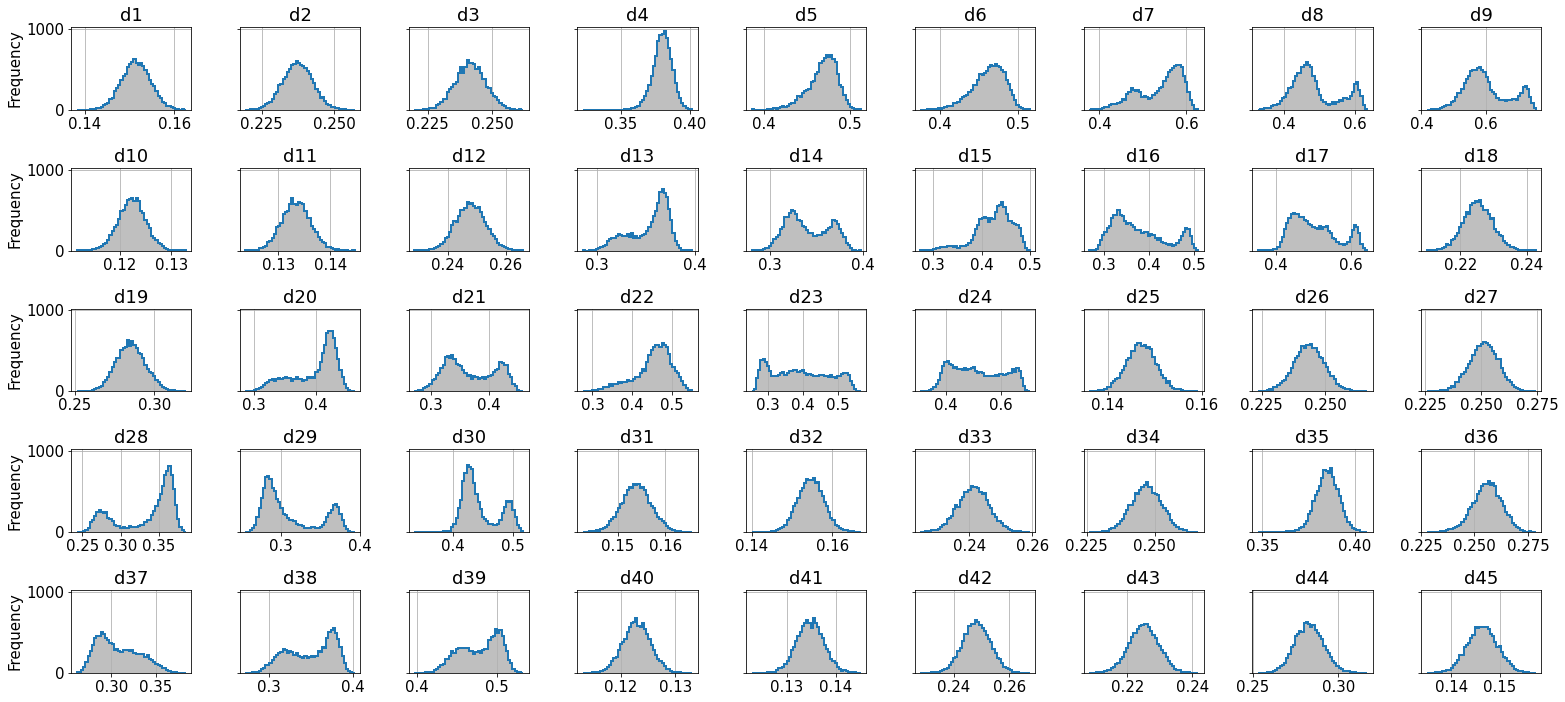

In [90]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    newdata[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    newdata[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [91]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':6,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": True,
              "step": 1 #se prendo tutti i valori fallisce il cholesky decomposition.. issue con pytorch
              }
#--------------------------------------#

In [92]:
lags = np.linspace(0.5,50,50)
time = []
torch.manual_seed(21)
timescale = np.empty(len(lags))
for i,lag in enumerate(lags):
    train_parameters["lag_time"] = lag
    #print("lag time ", lag)
    model,logweight,X,names = training(newdata,sim_parameters["beta"],train_parameters)

    #-- move the model back to cpu for convenience --# 
    model.to('cpu')

    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]

[0.07639891 0.21559548 0.24578071 0.258733   0.26063296 0.25784457
 0.25703454 0.2502861  0.23676153 0.21155979 0.19549066 0.17790198
 0.15869987 0.1343388  0.1173903  0.11402822 0.09639706 0.07832214
 0.06220419 0.05296656 0.03534167 0.02882672 0.02326132 0.0123039
 0.00699012 0.01404509 0.00371072 0.00551778 0.00126741 0.00561536
 0.00282522 0.00564741 0.00654946 0.00302019 0.00974725 0.01431917
 0.0068614  0.01151563 0.00200792 0.00796064 0.01092012 0.0034385
 0.01320706 0.00716118 0.00181907 0.0076124  0.01472797 0.01258036
 0.00680073 0.00806566]
[ 0.5         1.51020408  2.52040816  3.53061224  4.54081633  5.55102041
  6.56122449  7.57142857  8.58163265  9.59183673 10.60204082 11.6122449
 12.62244898 13.63265306 14.64285714 15.65306122 16.66326531 17.67346939
 18.68367347 19.69387755 20.70408163 21.71428571 22.7244898  23.73469388
 24.74489796 25.75510204 26.76530612 27.7755102  28.78571429 29.79591837
 30.80612245 31.81632653 32.82653061 33.83673469 34.84693878 35.85714286
 36.8

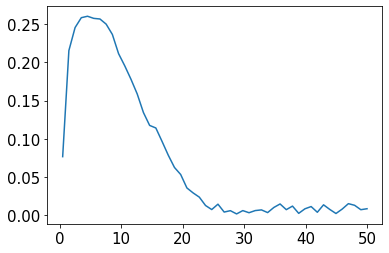

In [93]:
plt.plot(lags,timescale)
print(timescale)
print(lags)

## DeepTICA Analysis and Export

In [94]:
torch.manual_seed(21)
train_parameters["lag_time"] = 4.5
model,logweight,X,names = training(newdata,sim_parameters["beta"],train_parameters,tprime=None)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2] )

timescales:  [7.739122   3.7361972  2.3012211  1.7519088  1.661856   1.6271623
 1.5476947  1.5021919  1.4862878  1.4588728  1.4173454  1.3807398
 1.3636842  1.3186579  1.2590517  1.2050992  1.1868794  1.1096717
 1.0707128  1.046704   0.958226   0.82606286 0.6944426         nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
eigenvalues:  [ 0.5590808   0.2998619   0.14149602  0.0766407   0.06668231  0.06294143
  0.05460934  0.05000548  0.04842798  0.04574955  0.0417962   0.0384221
  0.03688744  0.0329567   0.02804013  0.0238939   0.02256274  0.01733108
  0.01495353  0.01357929  0.00913011  0.00430694  0.00153378 -0.00081186
 -0.00440414 -0.0056956  -0.00730689 -0.01141093 -0.01243322 -0.01616841
 -0.0179013  -0.02128364 -0.0229407  -0.02494628 -0.03339697 -0.03450683
 -0.03800825 -0.04313515 -0.0436292

In [95]:
X = newdata.filter(regex=train_parameters["descriptors"]).values
newdata["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
newdata["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
newdata["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
newdata["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

<AxesSubplot:ylabel='Frequency'>

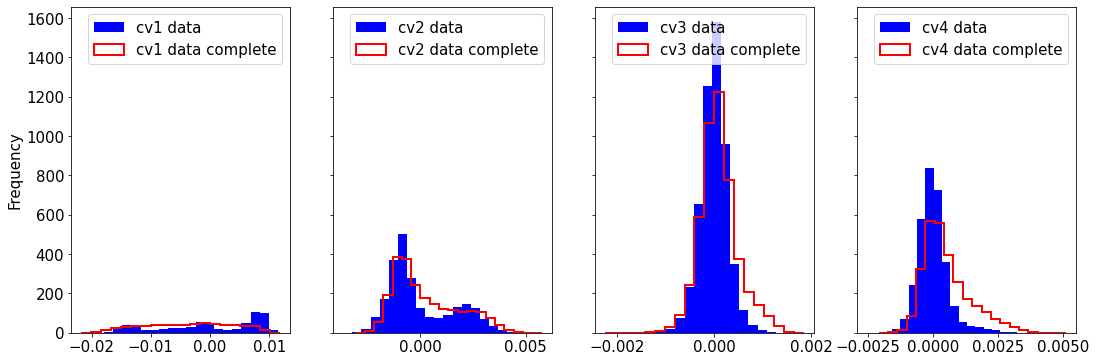

In [96]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
newdata.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
newdata.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
newdata.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
newdata.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,histtype='step',color="r",linewidth=2,label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,histtype='step',color="r",linewidth=2,label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,histtype='step',color="r",linewidth=2,label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,histtype='step',color="r",linewidth=2,label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

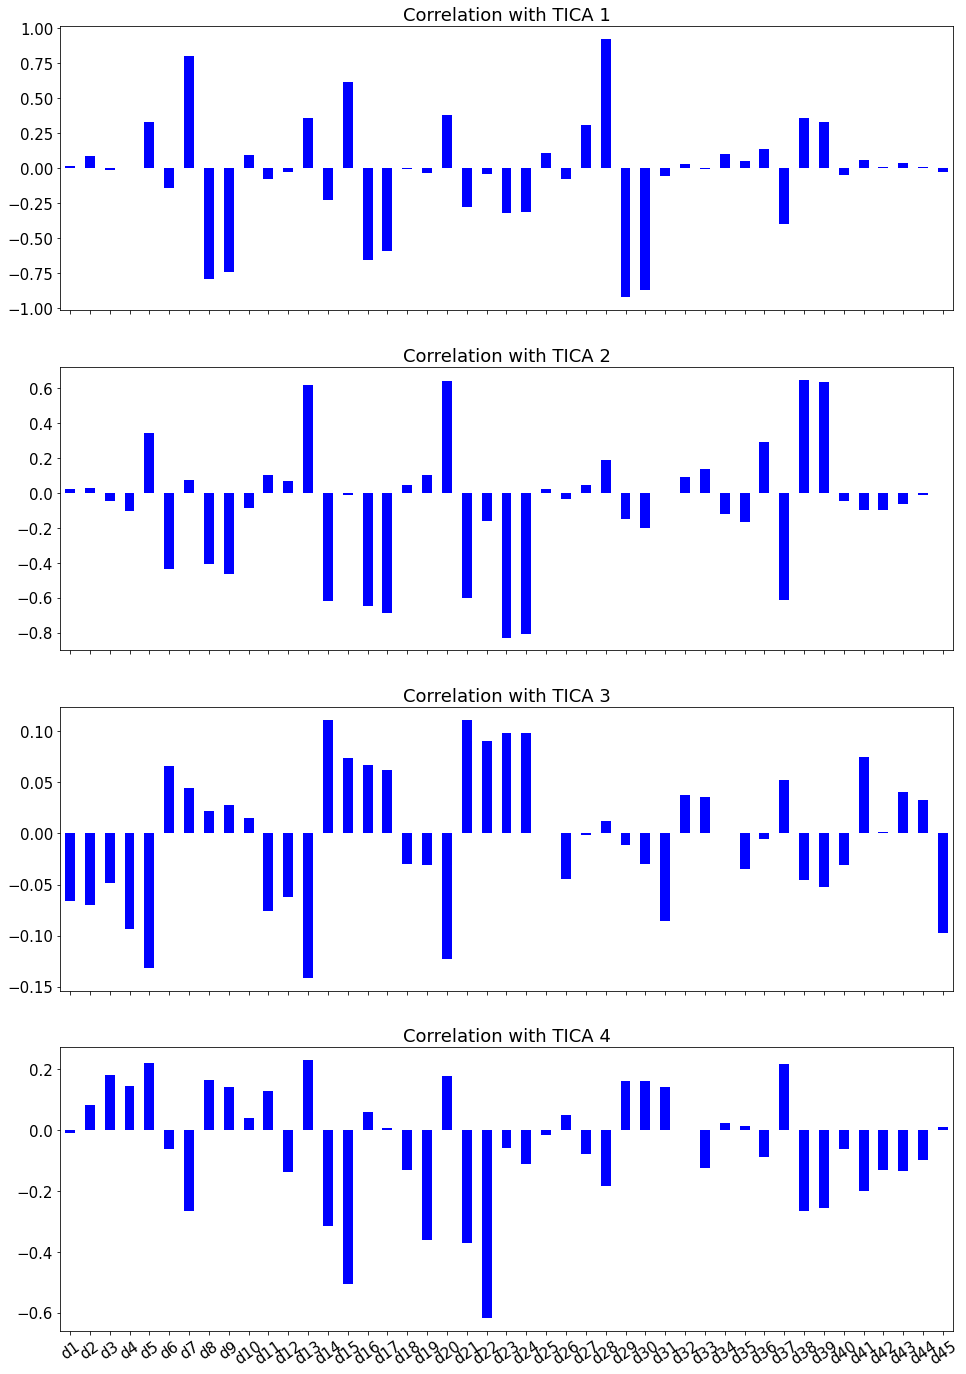

In [97]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(newdata.filter(regex=train_parameters["descriptors"]).columns)
    corr = newdata[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

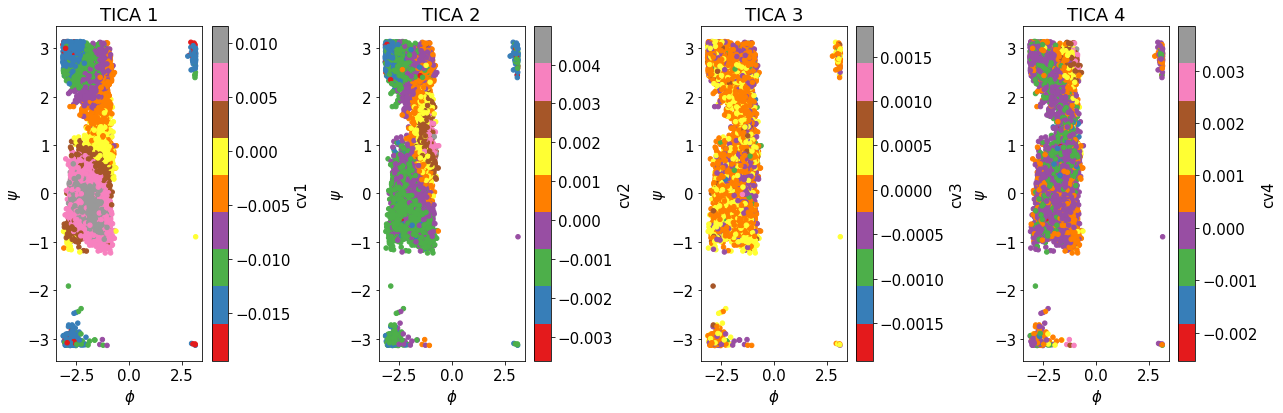

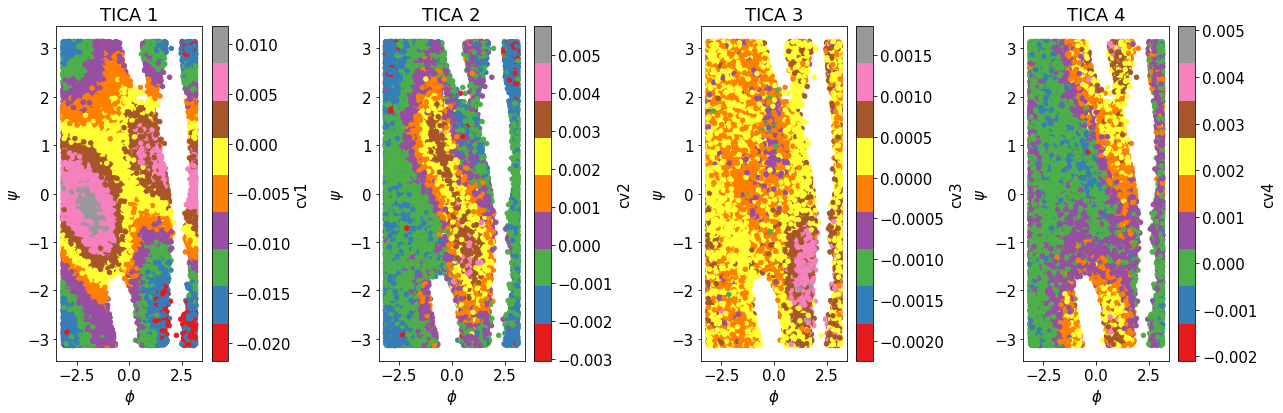

In [98]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    newdata.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

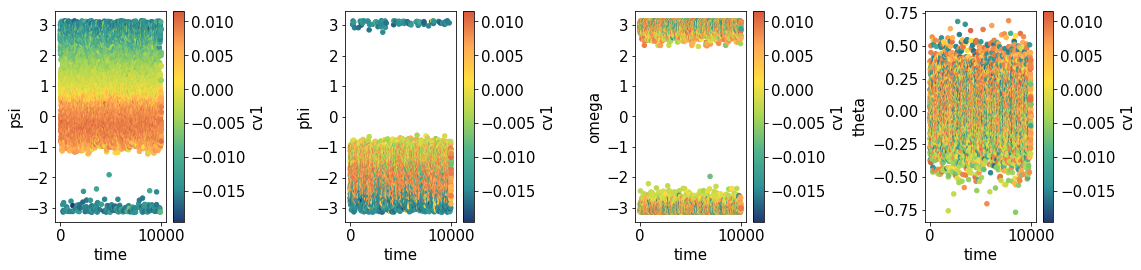

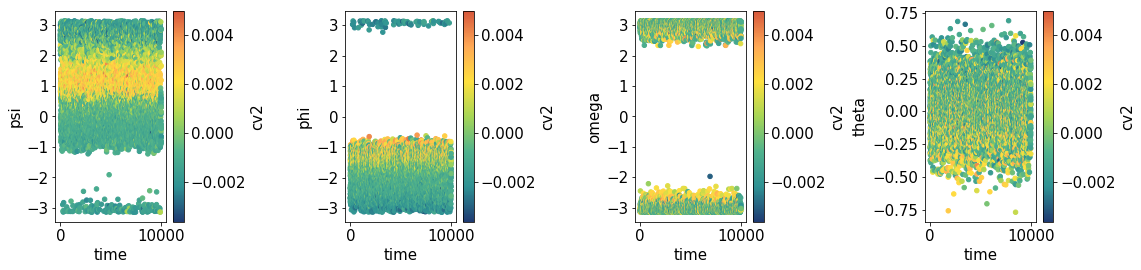

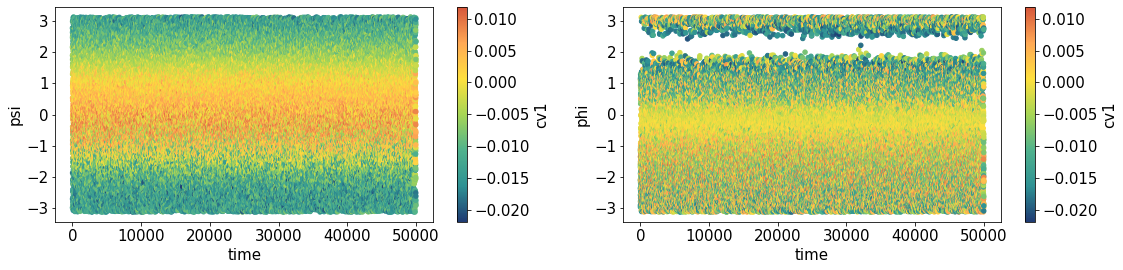

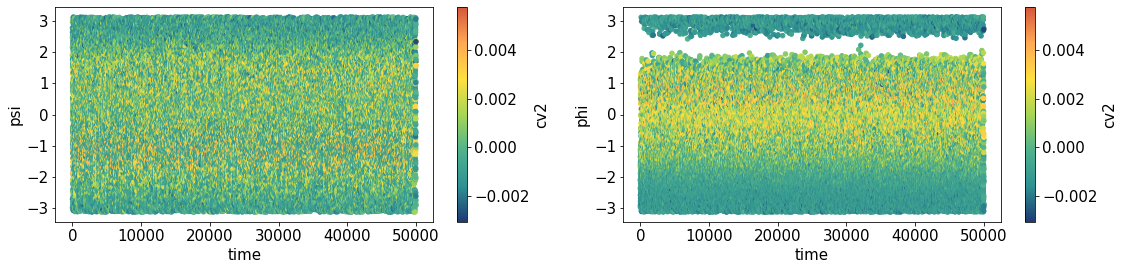

In [99]:
names = ["psi","phi","omega","theta"]
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    newdata.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    newdata.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### FES estimate from new cvs   

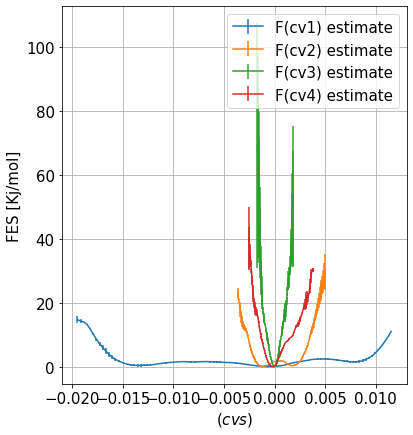

In [100]:
#-- estimation of Free Energy Surface --#
s = newdata.filter(regex="^cv").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(4):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate","F(cv3) estimate","F(cv4) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cvs)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [101]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

0.0013983025903450078